# Generative Adversarial Networks

In this notebook we will experiment with Generative Adversarial Networks for superresolution.

In [ ]:
!wget --output-document sres.zip https://drive.google.com/uc?id=1DCtjTsgO4LYweU5OnYFrj0Snnef9WLn2
!unzip -o sres.zip

Define data loader

In [2]:
import imageio
from glob import glob
import numpy as np
import matplotlib.pyplot as plt

class DataLoader():
    def __init__(self, mode = 'L'):
        self.mode =  mode
        self.input_shape = None
        self.output_shape = None
        
    
    def imread(self, path):
        return imageio.imread(path, pilmode=self.mode).astype(float)

    def load_data(self, batch_size=1, is_testing=False):
        data_type = "train" if not is_testing else "test"

        path = glob('./sres/{}/source/*'.format(data_type))

        batch_images = np.random.choice(path, size=batch_size) if not is_testing else path

        imgs_src = []
        imgs_trg = []
        for img_path in batch_images:
            img_src = self.imread(img_path)
            img_trg = self.imread(img_path.replace('source', 'target'))

            img_src = np.expand_dims(img_src, axis=2) 
            img_trg = np.expand_dims(img_trg, axis=2) 
            
            imgs_trg.append(img_trg)
            imgs_src.append(img_src)

        imgs_trg = np.array(imgs_trg) / 127.5 - 1.
        imgs_src = np.array(imgs_src) / 127.5 - 1.
        self.input_shape = imgs_src.shape[1:]
        self.output_shape = imgs_trg.shape[1:]

        return imgs_src, imgs_trg

    def single_img(self, file_name):
        img_src = self.imread(file_name)
        return np.array([img_src]) / 127.5 - 1.

Define the model

In [3]:
%tensorflow_version 2.x
import os
import scipy
import datetime
from PIL import Image
import numpy as np
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, Concatenate, PReLU, LeakyReLU
from tensorflow.keras.layers import BatchNormalization, Activation, ZeroPadding2D, Add
from tensorflow.keras.layers import UpSampling2D, Conv2D

class SRGAN:
    def __init__(self, input_size, output_size):
        self.channels = 1
        self.width = output_size[0]
        self.height = output_size[1]
        self.shape = (self.height, self.width, self.channels)
        self.input_shape = (input_size[1], input_size[0], self.channels)

        # Number of residual blocks in the generator
        self.n_residual_blocks = 16

        # Number of filters in the first layer of G and D
        self.gf = 64
        self.df = 64

        zoom = output_size[0] // input_size[0]
        self.upsampling_levels = int(np.log(zoom)/np.log(2))


        # Calculate output shape of D (PatchGAN)
        patch_width = -(-self.width // 2**4)
        patch_height = -(-self.height // 2**4)
        self.disc_patch = (patch_height, patch_width, 1)

        self.optimizer = Adam(0.0002, 0.5)

        # We use a pre-trained VGG19 model to extract image features from the target
        # image and the generated images and minimize the mse between them
        self.vgg = self.get_vgg()

        self.discriminator = self.get_discriminator()

        self.generator = self.get_generator()

        self.gan = self.get_gan(self.discriminator, self.generator)

    def get_vgg(self):
        """
        Builds a pre-trained VGG19 model that outputs image features extracted at the
        third block of the model
        """
        # Set outputs to outputs of last conv. layer in block 3
        vgg19 = VGG19(include_top=False, weights="imagenet")
        #vgg19 = VGG19(input_shape=(440,512))

        #vgg19.outputs = [vgg19.layers[10].output]

        # Extract image features
        vgg_input = Input(shape=self.shape)
        a = Dense(3)(vgg_input)
        #vgg_output = vgg19(vgg_input)
        vgg_output = vgg19(a)
        
        #build the model
        vgg = Model(inputs=vgg_input, outputs=vgg_output)
        vgg.trainable = False
        vgg.compile(loss='mse', optimizer=self.optimizer)
        
        return vgg

    def get_discriminator(self):
        """
        Builds the discriminator
        """

        def d_block(layer_input, filters, strides=1, bn=True):
            """Discriminator layer"""
            d = Conv2D(filters, kernel_size=3, strides=strides, padding='same')(layer_input)
            d = LeakyReLU(alpha=0.2)(d)
            if bn:
                d = BatchNormalization(momentum=0.8)(d)
            return d

        disc_input = Input(shape=self.shape)
        
        d1 = d_block(disc_input, self.df, bn=False)
        d2 = d_block(d1, self.df, strides=2)
        d3 = d_block(d2, self.df*2)
        d4 = d_block(d3, self.df*2, strides=2)
        d5 = d_block(d4, self.df*4)
        d6 = d_block(d5, self.df*4, strides=2)
        d7 = d_block(d6, self.df*8)
        d8 = d_block(d7, self.df*8, strides=2)
        d9 = Dense(self.df*16)(d8)
        d10 = LeakyReLU(alpha=0.2)(d9)
        
        disc_output = Dense(1, activation='sigmoid')(d10)

        discriminator = Model(inputs=disc_input, outputs=disc_output)
        discriminator.compile(loss='binary_crossentropy',
            optimizer=self.optimizer)

        return discriminator

        
    def get_generator(self):
        """
        Builds the generator
        """
        def residual_block(layer_input, filters):
            """Residual block described in the SRGAN paper"""
            d = Conv2D(filters, kernel_size=3, strides=1, padding='same')(layer_input)
            d = Activation('relu')(d)
            d = BatchNormalization(momentum=0.8)(d)
            d = Conv2D(filters, kernel_size=3, strides=1, padding='same')(d)
            d = BatchNormalization(momentum=0.8)(d)
            d = Add()([d, layer_input])
            return d

        def deconv2d(layer_input):
            """Layers used during upsampling"""
            u = UpSampling2D(size=2)(layer_input)
            u = Conv2D(256, kernel_size=3, strides=1, padding='same')(u)
            u = Activation('relu')(u)
            return u

        gen_input = Input(shape=self.input_shape)

        # Pre-residual block
        c1 = Conv2D(64, kernel_size=9, strides=1, padding='same')(gen_input)
        c1 = Activation('relu')(c1)

        # Propogate through residual blocks
        r = residual_block(c1, self.gf)
        for _ in range(self.n_residual_blocks - 1):
            r = residual_block(r, self.gf)

        # Post-residual block
        c2 = Conv2D(64, kernel_size=3, strides=1, padding='same')(r)
        c2 = BatchNormalization(momentum=0.8)(c2)
        c2 = Add()([c2, c1])

        # Upsampling
        upsampling_hierarchy = [c2]
        for ul in range(self.upsampling_levels):
            upsampling_hierarchy.append(deconv2d(upsampling_hierarchy[-1]))

        gen_output = Conv2D(self.channels, 
            kernel_size=9, strides=1, padding='same', activation='tanh')(upsampling_hierarchy[-1])

        generator = Model(inputs=gen_input, outputs=gen_output)
        generator.compile(loss='mse', optimizer=self.optimizer)
        return generator

    def get_gan(self, discriminator, generator):
        """
        Builds the combined model of generator and discriminator
        """
        
        source_img = Input(shape=self.input_shape)
        target_img = Input(shape=self.shape)

        #generate fake image
        fake_target = generator(source_img)
        #generate features of the fake image
        fake_features = self.vgg(fake_target)

        # For the combined model we will only train the generator
        discriminator.trainable = False

        # Discriminator determines validity of the generated images
        validity = discriminator(fake_target)

        #build the model
        gan = Model([source_img, target_img], [validity, fake_features])
        gan.compile(loss=['binary_crossentropy', 'mse'],
                              loss_weights=[1e-4, 1],
                              optimizer=self.optimizer)
        return gan

    def train(self, data_loader, epochs=1000, batch_size=1, save_interval=5):

        print("Training")

        start_time = datetime.datetime.now()
        for epoch in range(epochs):
            # ----------------------
            #  Train Discriminator
            # ----------------------

            self.discriminator.trainable = True
    
            # Sample images
            source_img, target_img = data_loader.load_data(batch_size)

            #generate fake target
            fake_target = self.generator.predict(source_img)

            # Train the discriminators (original images = real / generated = Fake)
            valid = np.ones((batch_size,) + self.disc_patch)
            fake = np.zeros((batch_size,) + self.disc_patch)
            d_loss_real = self.discriminator.train_on_batch(target_img, valid)
            d_loss_fake = self.discriminator.train_on_batch(fake_target, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ------------------
            #  Train Generator
            # ------------------

            self.discriminator.trainable = False
            
            # Sample images
            source_img, target_img = data_loader.load_data(batch_size)

            # The generator wants the discriminators to label the generated images as real
            valid = np.ones((batch_size,) + self.disc_patch)
           
            # Extract ground truth image features using pre-trained VGG19 model
            image_features = self.vgg.predict(target_img)

            # Train the generator
            g_loss = self.gan.train_on_batch([source_img, target_img], [valid, image_features])

            elapsed_time = datetime.datetime.now() - start_time

            # Plot the progress
            print ("Epoch %d,  time: %s, D-loss: %f, G1-loss: %f, G2-loss: %f" % (epoch+1, elapsed_time, d_loss, g_loss[0], g_loss[1]))

            # If at save interval => save model
            if epoch % save_interval == 0:
                self.save(epoch+1)

    def save(self, filePrefix):
        os.makedirs('models/{}', exist_ok=True)
        self.discriminator.save_weights('models/{}.dsc.h5'.format(filePrefix))
        self.generator.save_weights('models/{}.gen.h5'.format(filePrefix))
        self.gan.save_weights('models/{}.gan.h5'.format(filePrefix))
    
    def load(self, filePrefix):
        print ("Loading models.")
        self.discriminator.load_weights('models/{}.dsc.h5'.format(filePrefix))
        self.generator.load_weights('models/{}.gen.h5'.format(filePrefix))
        self.gan.load_weights('models/{}.gan.h5'.format(filePrefix))

    def predict(self, data_loader, file_name, output_file):
        print ("Predicting..")
        imgs_src = data_loader.single_img(file_name)
        imgs_fk = self.generator.predict(imgs_src).reshape(self.height, self.width)
        Image.fromarray(((imgs_fk + 1)*127.5).astype(np.uint8), mode='L').save(output_file)

Train model

In [ ]:
input_size = (128, 128)
output_size = (512, 512)

dl = DataLoader()
deconvgan = SRGAN(input_size, output_size)
deconvgan.train(dl, epochs=10, batch_size=1, save_interval=100)
#deconvgan.train(dl, epochs=3000, batch_size=1, save_interval=100)



In [5]:
#!mkdir models
#!pip install -U --no-cache-dir gdown --pre
#!gdown https://drive.google.com/uc?id=1rX2lO9a9KZ-AUnZ7XV65_-tp6kSEvdS6
#!unzip gan.zip
#!mv *.h5 models/
#dl = DataLoader()
#deconvgan.load('3000')

from PIL import Image
deconvgan.predict(dl, 'sres/test/source/0.png', '0-pred.png')

Predicting..


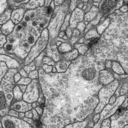

In [6]:
from IPython.display import Image

Image('sres/test/source/0.png')

In [ ]:
Image('0-pred.png')

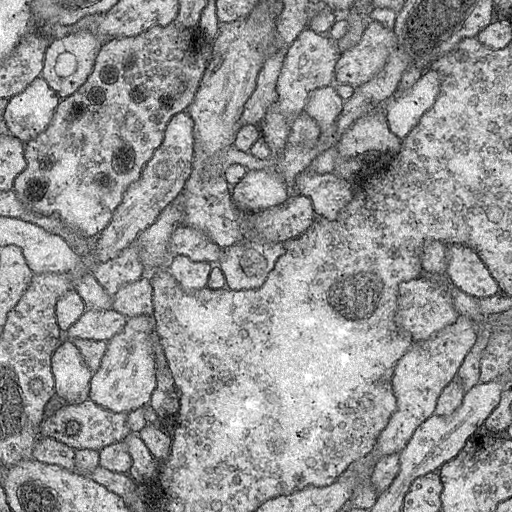

In [8]:
Image('sres/test/target/0.png')